# Data Filtering

## FIR Filter

In [269]:
# Import the required standard modules
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [270]:
# Generate a noisy sine-wave
dt = 0.1
t = np.arange(0, 20, dt)
(amp, noise_amp) = (5, 1)
x = amp * np.sin(t) + noise_amp *np.random.randn(len(t))

### Averaging Filter ("Running Mean")

In [271]:
win_length = 11
# Filter Coefficients
a = 1
b_avg = np.ones(win_length)/win_length

averaged = signal.lfilter(b_avg, a, x)

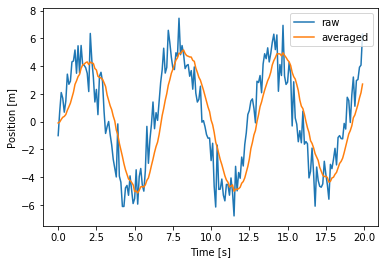

In [272]:
# Show the raw-data and the averaged signal
plt.plot(t, x, label='raw')
plt.plot(t, averaged, label='averaged')
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')    # We interpret the data here as "position"-data
plt.legend()

While an averaging filter does reduce the noise, it also induces a time-delay in the filtered signal.

### Differentiation

In [273]:
b_2pnt_diff = np.r_[1, -1]/dt
diff_2pnt = signal.lfilter(b_2pnt_diff, a, x)

Text(0, 0.5, 'Velocity [m/s]')

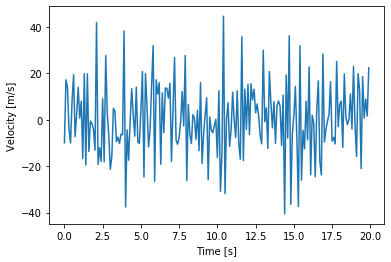

In [274]:
plt.plot(t, diff_2pnt)
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')

Well, not so useful :(

Here a *Savitzky-Golay* filter comes in handy, which allows us to smooth and differentiate the data in one go

### Savitzky-Golay Filter

In [275]:
diff_savgol = signal.savgol_filter(x, window_length=21, polyorder=3, deriv=1, delta=dt)

Text(0, 0.5, 'Velocity [m/s]')

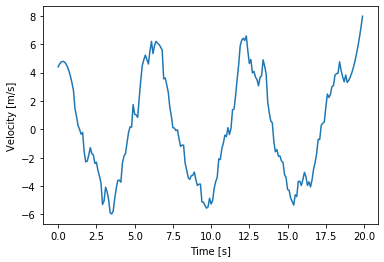

In [276]:
plt.plot(t, diff_savgol)
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')

That's a lot better! What you have to watch out for: at the beginning and at the end of every linear filter, one has to allow for transient artefacts!

Another advantage of Savitzky-Golay filters: they are much better at reproducing maxima and minima:

Text(0.5, 1.0, 'zoomed in')

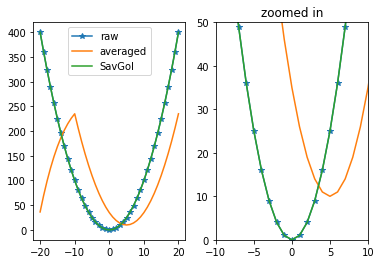

In [277]:
t = np.arange(-20, 21)
x = t**2

averaged = signal.lfilter(b_avg, 1, x)
sg_filtered = signal.savgol_filter(x, window_length=win_length, polyorder=3, deriv=0)

fig, axs = plt.subplots(1,2)
axs[0].plot(t,x, '-*', label='raw')
axs[0].plot(t, averaged, label='averaged')
axs[0].plot(t, sg_filtered, label='SavGol')
axs[0].legend()

axs[1].plot(t,x, '-*', label='raw')
axs[1].plot(t, averaged, label='averaged')
axs[1].plot(t, sg_filtered, label='SavGol')
axs[1].set_xlim([-10, 10])
axs[1].set_ylim([0, 50])
axs[1].set_title('zoomed in')


## IIR Filter

A good example of an IIR-filter is the *Butterworth-filter*, also called the *maximally flat* filter because it minimized transient artefacts in the filtered data.

Butterworth filter can be *low-pass*, *high-pass*, or *band-pass*. Below a *bandpass* example.

In [278]:
rate = 10
amps = np.r_[0.5, 1, 0.4]
freqs = np.c_[[0.05, 0.3, 3]]
omega = 2*np.pi * freqs

t = np.arange(0, 40, 1/rate)
x = amps @ np.sin(omega*t)

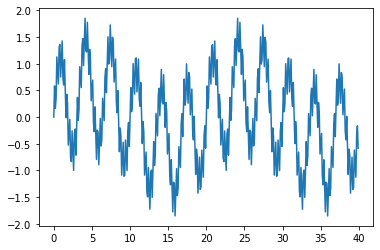

In [279]:
plt.plot(t,x)

In [280]:
# Butterworth filter
nyq = rate/2       # [Hz]
order = 5
band = np.r_[0.2, 1]    # [Hz]

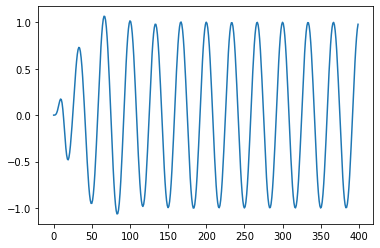

In [281]:
(b_band, a_band) = signal.butter(5, band/nyq, btype='bandpass')
filtered = signal.lfilter(b_band, a_band, x)
plt.plot(filtered)

#### Numerical Problems

For higher frequencies, numerical problems can arise:

In [282]:
# Same as above, only with a higher sampling rate
rate = 1000
nyq = rate/2

t = np.arange(0, 40, 1/rate)
x = amps @ np.sin(omega*t)

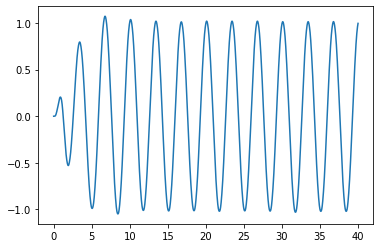

In [283]:
# This one still works
(b_low, a_low) = signal.butter(5, band[1]/nyq, btype='low')
(b_high, a_high) = signal.butter(5, band[0]/nyq, btype='high')

low_filtered = signal.lfilter(b_low, a_low, x)
band_filtered = signal.lfilter(b_high, a_high, low_filtered)
plt.plot(t, band_filtered)

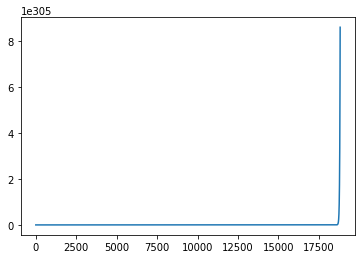

In [284]:
# But not this one
(b_band, a_band) = signal.butter(5, band/nyq, btype='bandpass')
filtered = signal.lfilter(b_band, a_band, x)
plt.plot(filtered)

Therefore it’s recommended to use second-order sections format when filtering, to avoid numerical error with transfer function (ba) format for the bandpass:

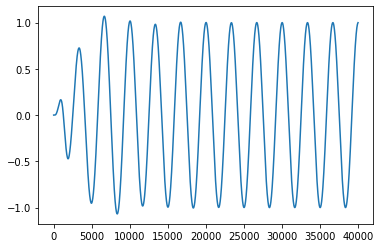

In [285]:
sos = signal.butter(5, band, 'bandpass', fs=rate, output='sos')
filtered = signal.sosfilt(sos, x)
plt.plot(filtered)